# Setup

In [1]:
# Import van gebruikte libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats
%matplotlib inline

## Functions

### Data Handling

In [2]:
# Converts scores copy-pasted from Google Sheets to a Python list
def to_scores(string_list):
    all_scores = []
    for score_string in string_list:
        score_list = score_string.split('\t')
        score_list = [int(score) for score in score_list]
        all_scores.append(score_list)
    return all_scores

In [3]:
# Retrieve the list of scores for the given mousepad name
def get_scores_list(mousepad_name):
    return score_lists.get(mousepad_name, [])  # Returns an empty list if the name is not found

### Simulations

In [4]:
# Simulates a score based on a list of scores and a reference score
def simulate_score(scores, reference):
    # Normalize scores
    test_scores_normalized = [(score / reference) * 100 for score in scores]

    # Calculate mean & standard deviation
    avg = np.mean(test_scores_normalized)
    std = np.std(test_scores_normalized, ddof=1)

    # Generate a simulated result
    simulated_result = np.random.normal(avg, std)

    return simulated_result

In [5]:
# Simulates a final score based on all scores of a pad
def simulate_final_score(scores, runs):
    final_score = 0
    for i in range(5):  # Loop through all 5 tests
        avg_score = 0
        for _ in range(runs):
            avg_score += simulate_score(scores[i], avg_reference[i])

        avg_score /= runs
        final_score += 2 * avg_score  # Double each result and add to final score

    return final_score

In [6]:
def simulate_final_scores(scores, amount=10000, runs=10):
    simulated_final_scores = [simulate_final_score(scores, runs) for _ in range(amount)]
    return simulated_final_scores

### Calculations

In [7]:
def lower_bound(sim_scores, accuracy):
    return round(np.percentile(sim_scores, (100 - accuracy) / 2))

In [8]:
def upper_bound(sim_scores, accuracy):
    return round(np.percentile(sim_scores, 100 - ((100 - accuracy) / 2)))

In [9]:
def calculate_superiority(scores_1, scores_2):
    # Scores mousepad 1
    one_nd = simulate_final_scores(scores_1, 10000, 10)

    # Scores mousepad 2
    two_nd = simulate_final_scores(scores_2, 10000, 10)

    yes = 0
    total = 0
    for score in two_nd:
        for score_rf in one_nd:
            if score_rf > score:
                yes += 1
            total += 1
    return yes / total * 100

In [10]:
def calculate_cv(mean, std_dev):
    return (std_dev / mean) * 100

In [11]:
def consistency_score(sim_scores):
    std_deviation = np.std(sim_scores, ddof=1)  # ddof=1 for sample standard deviation
    mean = np.mean(sim_scores)
    cv = calculate_cv(mean, std_deviation)

    return round(100 - (50 * cv))

In [12]:
# Function to calculate p-values from t-tests
def calculate_p_values(score_lists, test_index):
    mousepads = list(score_lists.keys())
    p_values_matrix = pd.DataFrame(index=mousepads, columns=mousepads, dtype=float)  # Ensure all values are float

    # Perform t-tests between each pair of mousepads
    for i in range(len(mousepads)):
        for j in range(len(mousepads)):
            if i == j:
                # Fill the diagonal with NaNs or a specific value, such as 1
                p_values_matrix.at[mousepads[i], mousepads[j]] = np.nan
            elif i < j:
                pad1, pad2 = mousepads[i], mousepads[j]
                scores1, scores2 = score_lists[pad1][test_index], score_lists[pad2][test_index]
                t_stat, p_value = stats.ttest_ind(scores1, scores2, equal_var=False)  # Added equal_var=False for Welch's t-test
                p_values_matrix.at[pad1, pad2] = p_value
                # Symmetrically fill the lower triangle to make the matrix complete
                p_values_matrix.at[pad2, pad1] = p_value

    return p_values_matrix

## Visualizations

In [13]:
def plot_p_value_heatmap(p_values_matrix, significance_level=0.1):
    # Ensure the matrix contains floats and fill diagonal with NaN
    p_values_matrix = p_values_matrix.astype(float)
    np.fill_diagonal(p_values_matrix.values, np.nan)

    # Create a mask for non-significant values (True where we want to mask)
    mask_non_significant = p_values_matrix >= significance_level

    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(p_values_matrix, annot=True, fmt=".3f", cmap=sns.light_palette((20, 60, 50), input="husl", reverse=True),
                mask=mask_non_significant, cbar=True, linewidths=.5, linecolor='grey', square=True)
    plt.title('P-Value Heatmap')
    plt.show()

## Data

### DataFrame

In [14]:
results = pd.DataFrame(columns=["Mousepad","Score"])
results["Mousepad"] = ["Desk (reference)", "Artisan Hien", "Fnatic JET", "Saturn", "Traigun", "Qck Heavy", "Qck Heavy (control)"]
results['Lower Bound'] = np.nan
results["Score"] = [1000, 1125, 1086, 1129, 1121, 1117, 1118]
results['Upper Bound'] = np.nan
results['Consistency Score'] = np.nan

### Measurements

In [15]:
# Reference Scores
reference_strings = ["111	116	115	115	110	111	120	113	117	116",
                    "70	76	73	69	72	64	72	70	73	75",
                    "47	49	52	57	51	55	47	47	51	53",
                    "1225	1275	1215	1400	1270	1460	1780	1630	1380	1585",
                    "417	516	444	399	469	428	517	478	492	452"]
reference_scores = to_scores(reference_strings)

# Artisan Hien Scores
hien_strings = ["124	117	122	126	127	121	125	122	133	132",
                "73	76	74	76	72	71	75	74	74	76",
                "53	56	56	62	59	57	59	56	56	63",
                "1760	1690	1725	1620	1645	1605	1950	1810	1725	1815",
                "525	527	541	515	526	495	503	568	491	586"]
hien_scores = to_scores(hien_strings)

# Fnatic JET Scores
jet_strings = ["117	112	125	119	122	116	122	117	129	124",
               "73	75	73	75	73	69	74	73	74	76",
               "55	56	56	53	56	58	59	62	64	57",
               "1385	1395	1545	1400	1560	1430	1800	1735	1700	1615",
               "493	560	505	523	513	492	513	520	531	532"]
jet_scores = to_scores(jet_strings)

# Saturn Scores
saturn_strings = ["129	125	123	130	129	122	133	130	128	132",
                  "75	73	72	71	75	74	77	79	72	75",
                  "56	60	58	64	57	57	56	60	59	59",
                  "1725	1705	1815	1730	1675	1860	1695	1750	1760	1780",
                  "552	510	492	479	517	536	512	511	494	495"]
saturn_scores = to_scores(saturn_strings)

# Traigun Scores
traigun_strings = ["128	120	121	126	126	119	126	129	132	128",
                   "75	78	76	70	73	80	78	72	78	76",
                   "52	58	56	54	59	59	55	55	57	59",
                   "1610	1725	1535	1645	1495	1890	1685	1745	1605	1890",
                   "586	559	489	543	497	538	545	539	489	546"]
traigun_scores = to_scores(traigun_strings)

# Qck Heavy Scores
qck_strings = ["123	123	121	120	126	120	129	124	126	132",
               "70	69	77	73	73	71	74	74	75	78",
               "56	58	59	58	64	56	55	58	59	52",
               "1685	1820	1715	1670	1835	1800	1785	1760	1610	1600",
               "560	543	520	463	539	468	528	545	512	503"]
qck_scores = to_scores(qck_strings)

# Qck Heavy (control) Scores
control_strings = ["123	128	126	130	122	124	123	126	133	129",
                   "71	74	73	74	76	73	73	72	71	74",
                   "53	56	63	53	55	55	56	59	58	57",
                   "1820	1530	1750	1715	1585	1795	1775	1955	1655	1700",
                   "540	571	463	502	534	561	550	504	500	511"]
control_scores = to_scores(control_strings)

# Set reference averages for normalizing scores
avg_reference = [np.mean(test_scores) for test_scores in reference_scores]

In [16]:
# Dictionary mapping mousepad names to their respective score lists
score_lists = {
    "Desk (reference)": reference_scores,
    "Artisan Hien": hien_scores,
    "Fnatic JET": jet_scores,
    "Saturn": saturn_scores,
    "Traigun": traigun_scores,
    "Qck Heavy": qck_scores,
    "Qck Heavy (control)": control_scores,
    # Add more entries for other mousepads
}

# Statistical significance per scenario

Test 1 p-value matrix:


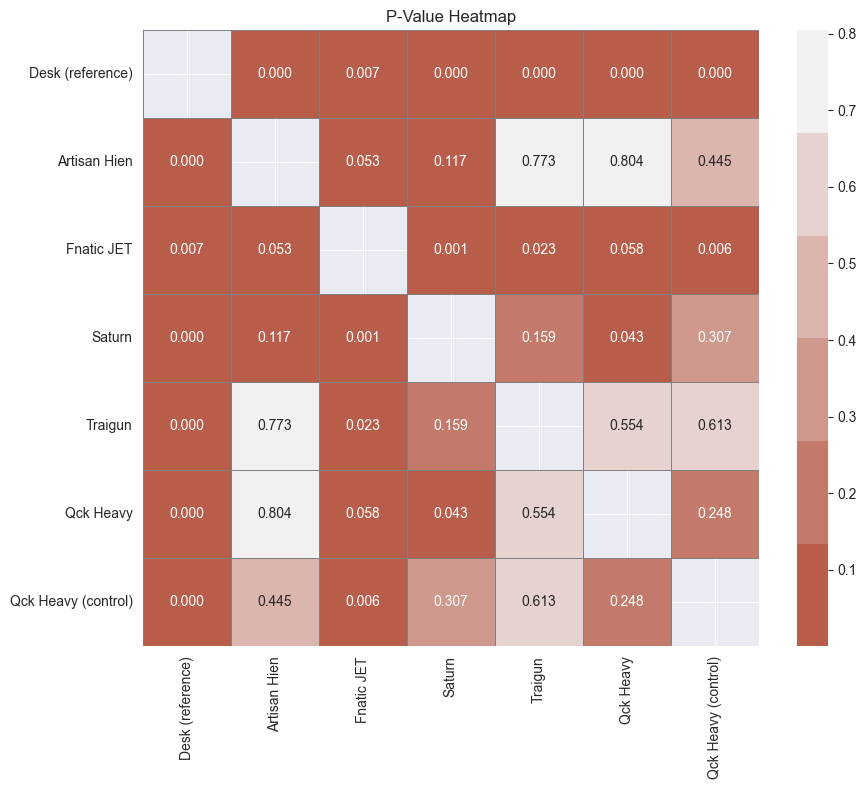

Test 2 p-value matrix:


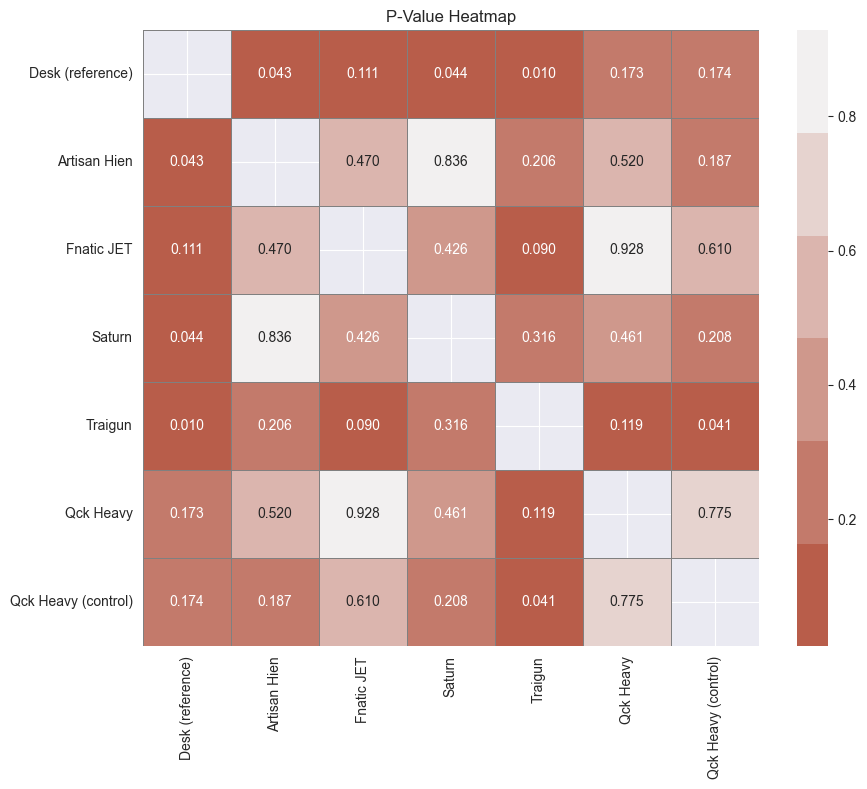

Test 3 p-value matrix:


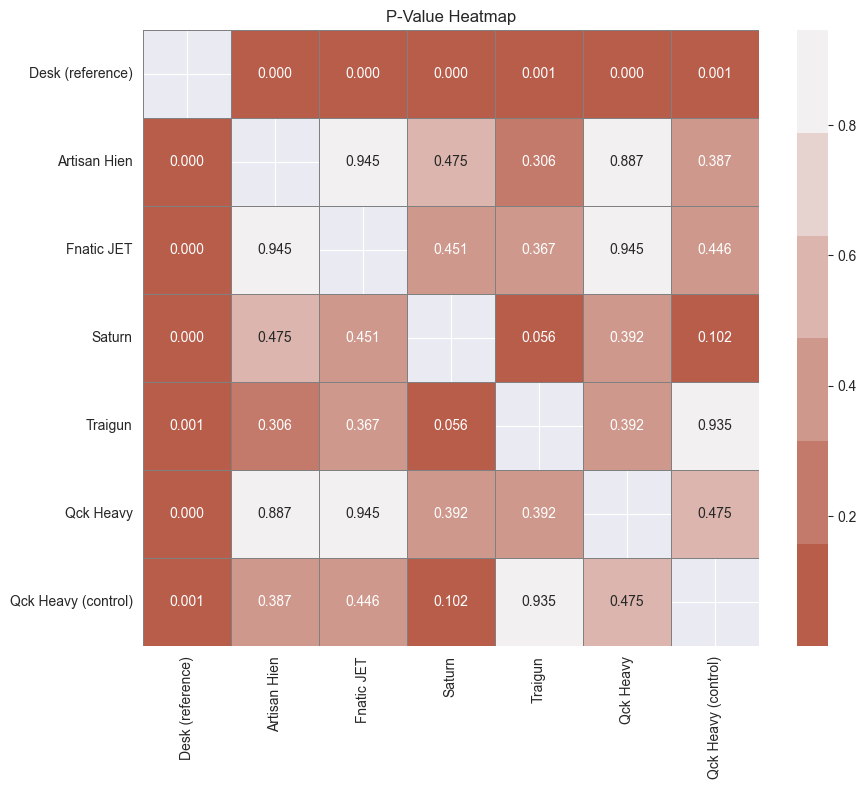

Test 4 p-value matrix:


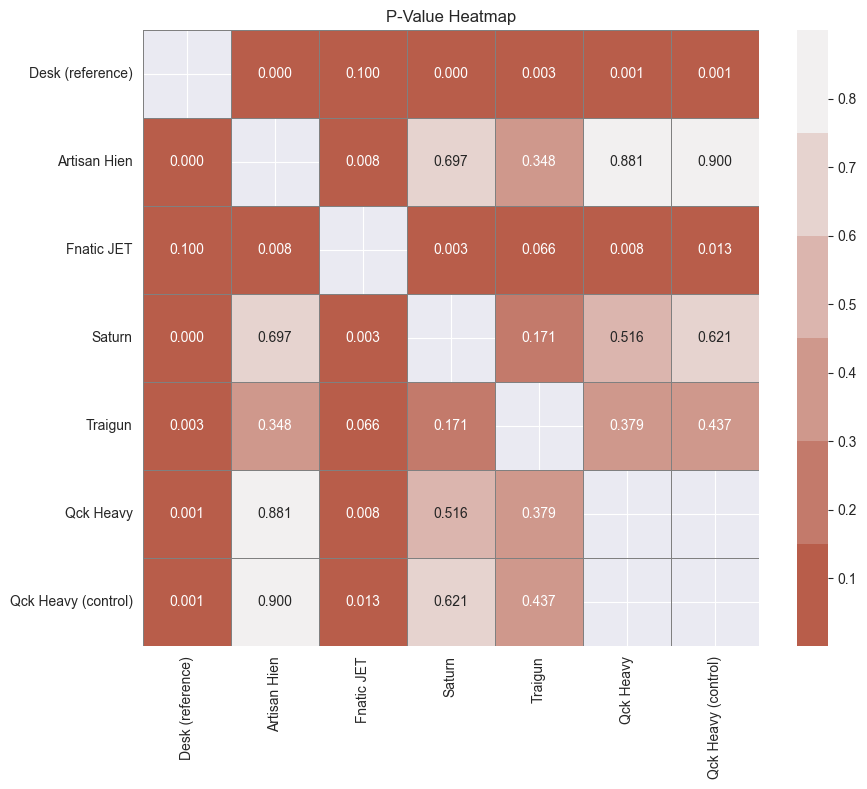

Test 5 p-value matrix:


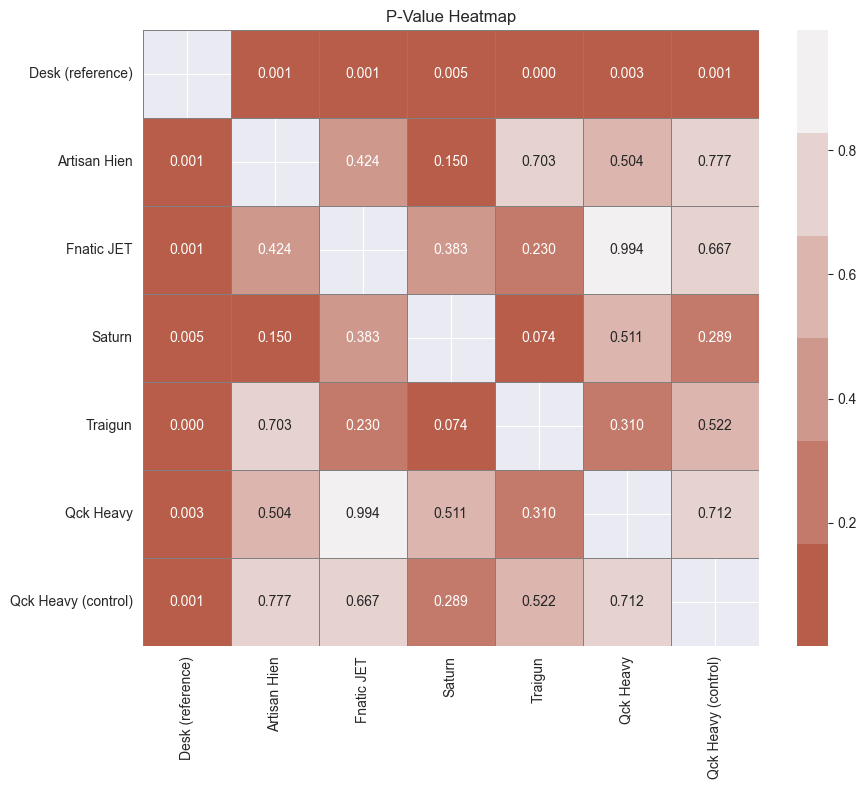

In [17]:
# Dictionary to hold the p-value matrices for each test set
p_values_overview = {}

# Calculate the p-values for each test
for test_index in range(5):  # Assuming there are 5 tests
    p_values_overview[f'Test {test_index+1}'] = calculate_p_values(score_lists, test_index)

# Plot heatmaps for each test set
for test_name, p_values_matrix in p_values_overview.items():
    print(f"{test_name} p-value matrix:")
    plot_p_value_heatmap(p_values_matrix, 1)

# Simulation 1: Standard

In [18]:
# Iterate over each mousepad and calculate bounds & consistency rating
for index, row in results.iterrows():
    mousepad_name = row['Mousepad']
    scores_list = get_scores_list(mousepad_name)
    sim_scores = simulate_final_scores(scores_list, 5000)
    lb = lower_bound(sim_scores, 90)
    ub = upper_bound(sim_scores, 90)
    cs = consistency_score(sim_scores)
    results.at[index, 'Consistency Score'] = cs
    results.at[index, 'Lower Bound'] = lb
    results.at[index, 'Upper Bound'] = ub

results['Consistency Score'] = results['Consistency Score'].astype(int)
results['Lower Bound'] = results['Lower Bound'].astype(int)
results['Upper Bound'] = results['Upper Bound'].astype(int)

In [19]:
results

,Mousepad,Score,Lower Bound,Upper Bound,Consistency Score
0,Desk (reference),1000,982,1019,42
1,Artisan Hien,1125,1112,1139,64
2,Fnatic JET,1086,1071,1101,58
3,Saturn,1129,1120,1139,74
4,Traigun,1121,1106,1135,61
5,Qck Heavy,1117,1104,1130,65
6,Qck Heavy (control),1118,1105,1131,63


In [20]:
sorted_results = results.sort_values(by='Score', ascending=False)
sorted_results

,Mousepad,Score,Lower Bound,Upper Bound,Consistency Score
3,Saturn,1129,1120,1139,74
1,Artisan Hien,1125,1112,1139,64
4,Traigun,1121,1106,1135,61
6,Qck Heavy (control),1118,1105,1131,63
5,Qck Heavy,1117,1104,1130,65
2,Fnatic JET,1086,1071,1101,58
0,Desk (reference),1000,982,1019,42


              Mousepad  Score  Lower Bound  Upper Bound  Consistency Score
0               Saturn   1129         1120         1139                 74
1         Artisan Hien   1125         1112         1139                 64
2              Traigun   1121         1106         1135                 61
3  Qck Heavy (control)   1118         1105         1131                 63
4            Qck Heavy   1117         1104         1130                 65
5           Fnatic JET   1086         1071         1101                 58
6     Desk (reference)   1000          982         1019                 42


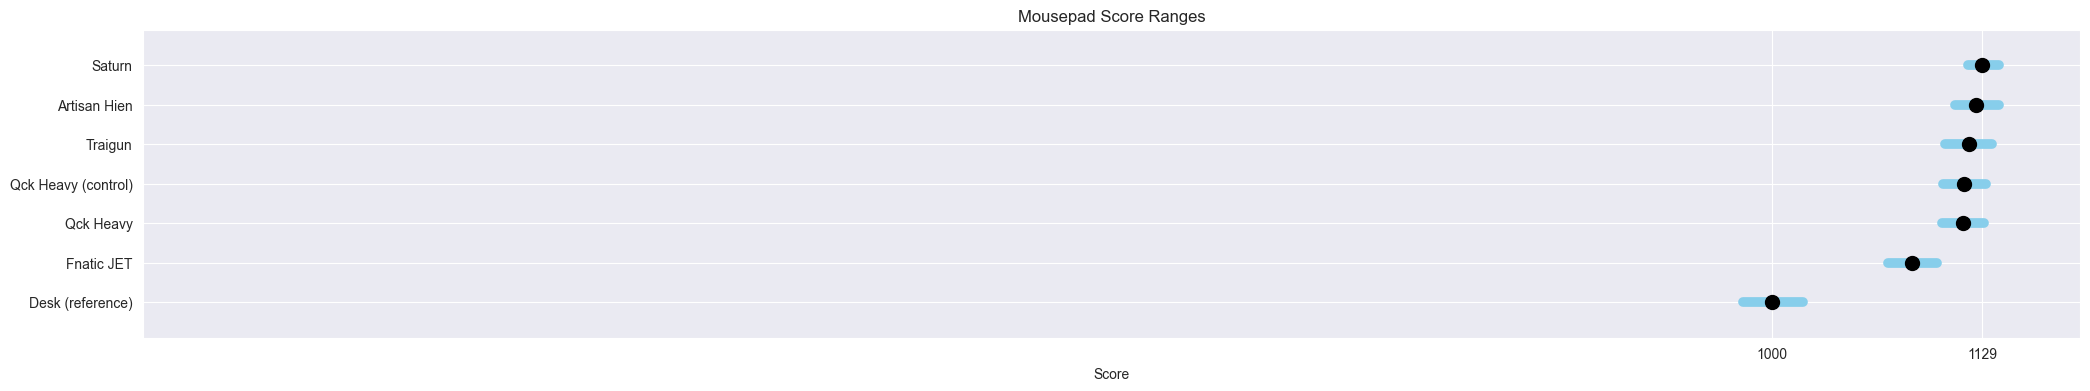

In [21]:
df = sorted_results.copy().reset_index(drop=True)
print(df)
# Create a horizontal bar plot with adjusted line width and padding
plt.figure(figsize=(25, 4))  # Adjust figure size for better vertical spacing
for index, row in df.iterrows():
    plt.plot([row['Lower Bound'], row['Upper Bound']], [index, index], '-', color='skyblue', lw=7, zorder=1)  # Reduced line width
    plt.plot(row['Score'], index, 'o', color='black', ms=10, zorder=2)

# Adjust the y-ticks range to add extra space at the top and bottom
plt.yticks(np.arange(-1, len(df) + 1, 1), [""] + list(df['Mousepad']) + [""])  # Adding empty strings for padding
plt.xlabel('Score')
plt.title('Mousepad Score Ranges')

# Adjust x-axis limits to ensure full visibility of ranges
plt.gca().set_xlim([min(df['Lower Bound']) - 50, max(df['Upper Bound']) + 50])

# Invert y-axis to have the reference desk at the bottom
plt.gca().invert_yaxis()
plt.gca().set_xlim([0, max(df['Upper Bound']) + 50])

# Remove x-axis ticks
plt.xticks([1000, 1129])

# Padding top & bottom
plt.margins(y=0.15)

plt.show()

In [25]:
calculate_superiority(saturn_scores, jet_scores)

99.99307200000001

# Strength Index

In [23]:
for test_index in range(5):  # Assuming there are 5 test sets
    # Calculate average scores for this test set
    avg_scores = {mp: np.mean(score_lists[mp][test_index]) for mp in score_lists}
    # Create a temporary DataFrame for merging
    temp_df = pd.DataFrame.from_dict(avg_scores, orient='index', columns=[f'Test {test_index + 1} Avg Score'])
    temp_df['Mousepad'] = temp_df.index
    # Merge with the results DataFrame
    results = results.merge(temp_df, on='Mousepad', how='left')
    # Rank mousepads based on average scores and calculate RSI (higher average should give higher RSI)
    results[f'Test {test_index + 1} RSI'] = results[f'Test {test_index + 1} Avg Score'].rank(ascending=True, method='min')
    # Normalize RSI scores (higher score should mean higher RSI)
    results[f'Test {test_index + 1} RSI'] = (results[f'Test {test_index + 1} RSI'] - 1) / (len(results) - 1) * 100
    # Round the RSI scores
    results[f'Test {test_index + 1} RSI'] = results[f'Test {test_index + 1} RSI'].round(2)
    # Round the average scores
    results[f'Test {test_index + 1} Avg Score'] = results[f'Test {test_index + 1} Avg Score'].round(2)

# Results DataFrame now contains the original data along with the RSI for each test set


In [24]:
results

,Mousepad,Score,Lower Bound,Upper Bound,Consistency Score,Test 1 Avg Score,Test 1 RSI,Test 2 Avg Score,Test 2 RSI,Test 3 Avg Score,Test 3 RSI,Test 4 Avg Score,Test 4 RSI,Test 5 Avg Score,Test 5 RSI
0,Desk (reference),1000,982,1019,42,114.4,0.00,71.4,0.00,50.9,0.00,1422.0,0.00,461.2,0.00
1,Artisan Hien,1125,1112,1139,64,124.9,50.00,74.1,66.67,57.7,83.33,1734.5,83.33,527.7,83.33
2,Fnatic JET,1086,1071,1101,58,120.3,16.67,73.5,50.00,57.6,66.67,1556.5,16.67,518.2,50.00
3,Saturn,1129,1120,1139,74,128.1,100.00,74.3,83.33,58.6,100.00,1749.5,100.00,509.8,16.67
4,Traigun,1121,1106,1135,61,125.5,66.67,75.6,100.00,56.4,16.67,1682.5,33.33,533.1,100.00
5,Qck Heavy,1117,1104,1130,65,124.4,33.33,73.4,33.33,57.5,50.00,1728.0,50.00,518.1,33.33
6,Qck Heavy (control),1118,1105,1131,63,126.4,83.33,73.1,16.67,56.5,33.33,1728.0,50.00,523.6,66.67
